# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)
## Class 08 Notebook — Regression Pt. 4: Logistic Regression + Survival Analysis  

A lot of the "expected value" objects we care about in sports are really probabilities in disguise:

- expected goals (xG): $\mathbb{E}[\text{Goal}] = P(\text{Goal})$
- win probability: $\mathbb{E}[\text{Win}] = P(\text{Win})$
- shot make probability: $\mathbb{E}[\text{Make}] = P(\text{Make})$

That's why logistic regression shows up everywhere: it is a principled way to model $P(Y=1\mid X)$ when $Y\in\{0,1\}$. But many sports questions are not "will it happen?" — they're "**when** will it happen?":

- time to first goal in a match
- time to injury in a season
- time until a roster change, substitution, or retirement

That's **survival analysis**: time-to-event modeling with censoring.

**Where we are in the course (very roughly):**
- Class 04: distributions, odds, surprise  
- Class 05: regression as a translation device (Moneyball)
- Class 06: expectation + likelihood (why probabilistic regressions look the way they do)
- Class 07: logistic regression intro (xG as $P(\text{goal} \mid \text{shot context})$)
- **Class 08 (today):** logistic regression in practice + survival analysis

As always, course materials live here: https://github.com/jkbren/cnet5442_sp26

In [1]:
# --- Imports and setup ---
import math
import json
import warnings
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss, brier_score_loss,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
)
from sklearn.calibration import calibration_curve

import statsmodels.api as sm
from statsmodels.duration.survfunc import SurvfuncRight
from statsmodels.duration.hazard_regression import PHReg

warnings.filterwarnings("ignore")

RNG = np.random.default_rng(7)

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
import sklearn, statsmodels
print("sklearn:", sklearn.__version__)
print("statsmodels:", statsmodels.__version__)


numpy: 1.22.0
pandas: 2.0.3
sklearn: 1.0.2
statsmodels: 0.14.1



### Conventions
- Binary outcomes: $Y\in\{0,1\}$.
- Conditional probabilities: $p(x)=P(Y=1\mid X=x)$.
- Logistic function: $\sigma(z)=\frac{1}{1+e^{-z}}$.

## Part 0 — Micro recap: expectation and why probabilities are expectations

A huge amount of sports analytics is just different ways of estimating an expectation.

### Bernoulli outcomes
Many sport outcomes are naturally binary:

- shot is a goal? $Y\in\{0,1\}$
- free throw make? $Y\in\{0,1\}$
- team wins? $Y\in\{0,1\}$
- player gets injured in the next week? $Y\in\{0,1\}$

For a Bernoulli random variable $Y$ with success probability $p$: $ E[Y] = 1\cdot p + 0\cdot (1-p) = p $.

Conditional on features $X$ (shot distance, angle, game state, etc.), we get: $ E[Y\mid X] = P(Y=1\mid X) $.

So if we build a model that outputs $\hat p(x)$, we are building a sort of expected value machine for a Bernoulli outcome.

That is why:
- xG is an expectation (expected goals),
- expected points can be an expectation,
- win probability is an expectation of winning.

The question is: **how do we build a model for $p(x)$ that stays in $[0,1]$?**

A recurring problem in sports analytics is that people throw around words like *xG*, *win probability*, or *calibration* as if everyone means the same thing. For today, here's what we mean:

### Expected goals (xG)
At the single-shot level:

- A shot outcome is often modeled as $Y\in\{0,1\}$ (goal / no-goal).
- If $p_i = P(Y_i=1\mid X_i)$ is the goal probability for shot $i$ given its context $X_i$, then $ \mathbb{E}[Y_i\mid X_i] = p_i $

That number $p_i\in[0,1]$ is what people colloquially call "the xG of the shot." At the team (or match) level we use linearity of expectation:

$$
\mathbb{E}\left[\sum_{i=1}^m Y_i\right] = \sum_{i=1}^m \mathbb{E}[Y_i] = \sum_{i=1}^m p_i.
$$

So: team xG = sum of shot probabilities.

Two important real-world wrinkles:

- **Pre-shot xG vs post-shot xG.**  
  Pre-shot xG uses information available *at shot time* (location, angle, assist type, defenders, etc.).  
  Post-shot xG (sometimes "xGOT") adds shot placement/velocity information and answers a different question: "given where/how it was struck, what is the chance it becomes a goal?"

- **Different providers disagree** because:
  - they label events differently (what counts as a shot? a big chance?),
  - they have different features (event data vs tracking data),
  - they fit different model classes (logistic regression, boosted trees, neural nets, …),
  - they sometimes target different outcomes (pre-shot vs post-shot).


### Expected points (basketball)
Same idea, different outcome space... If a shot is worth 2 points with probability $p_2$ and 3 points with probability $p_3$ (and 0 otherwise), then expected points for a shot attempt is:

$$
\mathbb{E}[\text{points}] = 2\,p_2 + 3\,p_3.
$$

You'll see this again when we build "expected points by location."

### Win probability
Win probability (WP) is just a conditional probability:

$$
\mathrm{WP}(\text{game state}) = P(\text{win}\mid\text{game state}).
$$

It's useful because many downstream questions are *expected value* questions:
- "Should we go for it on 4th down?"  
- "Should we pull the goalie?"  
- "Should we foul?"  

All of those depend on how actions move win probability.

### Corsi and Fenwick (hockey)
These show up whenever someone tries to quantify "shot attempt pressure."

- **Corsi** = all shot attempts: goals + saves + misses + blocked shots.  
- **Fenwick** = unblocked shot attempts: goals + saves + misses.

They're not the same as xG, but they're often used as *volume* measures: "did you create attempts?"

### Calibration
If a model says "this shot is $0.12$ xG," calibration asks:

> Among all shots the model labels as $0.12$, do about 12% of them become goals?

Calibration matters *a ton* when you **sum probabilities** (xG, expected points, WP), because miscalibration systematically biases your totals.

(We'll look at calibration plots later.)


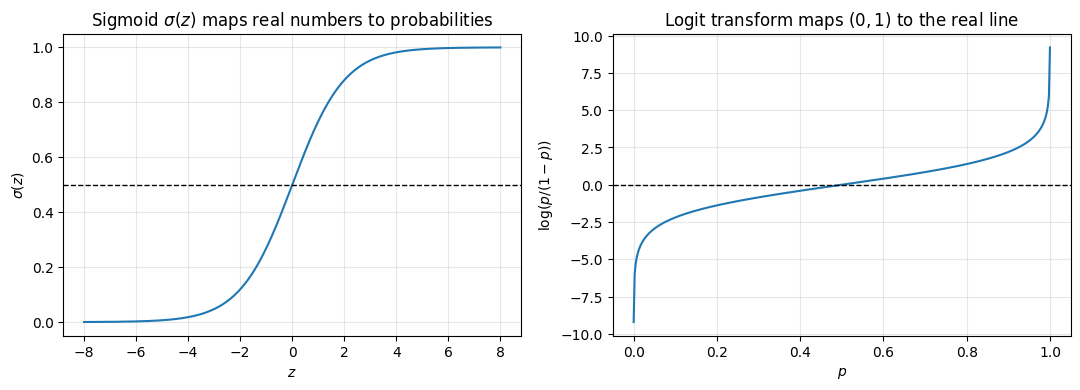

In [2]:
# Visualize the sigmoid and the logit transform

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

zs = np.linspace(-8, 8, 400)
ps = sigmoid(zs)

fig, ax = plt.subplots(1,2,figsize=(13,4), dpi=100)
ax[0].plot(zs, ps)
ax[0].set_title("Sigmoid $\\sigma(z)$ maps real numbers to probabilities")
ax[0].set_xlabel("$z$")
ax[0].set_ylabel("$\\sigma(z)$")
ax[0].axhline(0.5, linestyle="--", linewidth=1, color='k')
ax[0].grid(True, alpha=0.3)

# logit is undefined exactly at 0 and 1, so we clip.
pgrid = np.linspace(1e-4, 1-1e-4, 400)
logit = np.log(pgrid/(1-pgrid))

ax[1].plot(pgrid, logit)
ax[1].set_title("Logit transform maps $(0,1)$ to the real line")
ax[1].set_xlabel("$p$")
ax[1].set_ylabel("$\\log(p/(1-p))$")
ax[1].axhline(0, linestyle="--", linewidth=1, color='k')
ax[1].grid(True, alpha=0.3)

plt.show()

## Part 1 — Why survival analysis comes right after logistic regression

Logistic regression models a probability of an event: $ P(Y=1\mid X) $.

Survival analysis models *when* an event happens.

Examples in sports analytics:
- time until first goal in a match
- time until next substitution
- time until injury during a season
- time until a team loses its win streak
- time until a player "retires" / exits a league

Survival analysis is needed because of *censoring*.

### Censoring (the key data issue)

Often you don't observe the event for everyone:

- a match ends before the first goal (no first goal time exists)
- a season ends before a player gets injured
- you stop collecting data before the career ends

That is **right censoring**: you know the event time is *after* your last observation time.

Survival methods incorporate this information correctly instead of dropping those observations.

### Tiny history / why it's called "survival" (even when nobody is dying)

Survival analysis grew up in a few places at once:

- Actuarial science / demography: "life tables" were used to summarize mortality and survival patterns long before modern regression models.  
- Biostatistics: modern survival methods became a standard toolkit in medicine because *time-to-event + censoring* is everywhere in clinical studies.  
- Reliability engineering: the same math describes "time until a machine fails."  

The name is a bit misleading: in sports we rarely mean "survival" literally. We just mean:

> A random time $T$ until *something happens*.

Some historical milestones you'll see in basically every survival textbook:

- **Kaplan–Meier (1958):** the product-limit estimator of the survival curve (what we now call the KM curve).
- **Cox (1972):** the proportional hazards model, fit via a clever trick called **partial likelihood** that avoids specifying the baseline hazard $h_0(t)$.

(We'll use both today.)

___________

## Part 2 — Survival analysis fundamentals (core definitions)

Let $T$ be a nonnegative random variable: the time until an event.

### Survival function

$S(t)$ is the probability that the event has **not** happened by time $t$ (i.e., the survival probability past $t$).

$$
S(t) = P(T>t)
$$


### CDF and PDF

$F(t)$ is the probability the event **has** happened by time $t$; it is the complement of survival. The density $f(t)$ describes how probability mass is distributed over event times, and can be interpreted as the "instantaneous likelihood" of failing right around $t$ (for continuous $T$).

$$
F(t) = P(T\le t) = 1 - S(t), \quad f(t) = F'(t).
$$


### Hazard function (instantaneous event rate)

Intuition: "given you've survived to time $t$, how quickly do events happen right after $t$?"

The hazard $h(t)$ is an **instantaneous event rate**: among those who are still event-free at time $t$, it measures how rapidly events occur immediately after $t$ (it’s a rate, not a probability).

$$
h(t) = \lim_{\Delta t\to 0} \frac{P(t\le T < t+\Delta t \mid T\ge t)}{\Delta t}.
$$

Key identity: this shows the hazard equals the event-time density at $t$ divided by the probability of still being at risk at $t$, i.e., “instantaneous failures per unit time” among survivors.

$$
h(t) = \frac{f(t)}{S(t)}.
$$


### Cumulative hazard

$H(t)$ accumulates risk over time: it is the total hazard "exposure" from $0$ up to $t$ (so it grows as time passes).

$$
H(t) = \int_0^t h(u),du.
$$

Relationship with survival: this states that survival decays exponentially with accumulated hazard—large cumulative hazard implies small survival probability.

$$
S(t) = e^{-H(t)}.
$$

This last identity is extremely useful: if you can estimate $H(t)$, you can get $S(t)$.


## Part 3 — A synthetic survival dataset: time-to-injury during a season

We'll build a toy dataset at the **player-season** level, where each row is one player and the outcome is **days until first injury**.

- $T_i$ = the (possibly unobserved) true time until the player's first injury
- $C$ = the censoring time (season end, measured in days)

In real data, we often do **not** observe $T_i$ for everyone: some players make it to the end of the season without an injury. That produces **right censoring**:

- observed time $\tilde T_i = \min(T_i, C)$  
- event indicator $\delta_i = \mathbb{1}[T_i \le C]$ (1 if injured before season ends, 0 if censored)

We'll simulate covariates and then simulate $T_i$ from a simple proportional hazards model:

$$
h(t \mid x) = h_0(t)\exp(\beta^\top x).
$$

For simulation simplicity, we will take a **constant baseline hazard** $h_0(t)=\lambda$ (an exponential survival model). When we fit a Cox model later, it will *not* assume an exponential baseline.


______________
## Your turn: write `simulate_injury_survival(...)`

You will write a function that generates a synthetic right-censored time-to-injury dataset.

**Inputs**
- `n_players`: number of simulated players
- `season_days`: censoring time $C$ (season length)

**Outputs**
Return a `DataFrame` with columns:
- `time`: observed time $\tilde T_i = \min(T_i, C)$
- `event`: event indicator $\delta_i$ (1 = injury observed, 0 = censored)
- `age`, `min_per_game`, `prev_injury`: the covariates you simulated


### Step 1: Come up with some "model ingredients"




_____________

### Model ingredients
1. Simulate covariates:
   - `age` (clip to 18–40)
   - `min_per_game` (clip to 5–42)
   - `prev_injury` as Bernoulli(0.28)

2. Create the design matrix $X$ with *centered* continuous covariates:
   - $X_1 = \texttt{age} - 25$
   - $X_2 = \texttt{min_per_game} - 30$
   - $X_3 = \texttt{prev_injury}$

3. Use these true coefficients (higher = higher hazard = earlier injury):
   - $\beta = [0.06,\, 0.03,\, 0.55]$

4. Baseline hazard (per day):
   - $\lambda = 0.006$

5. Compute each player's hazard rate: 
    - $ \text{hazard}_i = \lambda \exp(\beta^\top x_i) $.

6. Sample true event times from an exponential distribution:
   - $T_i \sim \text{Exp}(\text{rate}=\text{hazard}_i)$

7. Apply right censoring at `season_days` to form `time` and `event`.

**Sanity checks**
- Print the observed event rate `df["event"].mean()`. With these settings it should be neither near 0 nor near 1.
- Look at the first few rows with `df.head()`.


In [4]:
# --- EXERCISE: Simulate right-censored time-to-injury data ---

def simulate_injury_survival(n_players=500, season_days=180, rng=RNG):
    """
    Simulate a player-season dataset for time-to-first-injury with right censoring.

    Returns
    -------
    df : pd.DataFrame
        Columns: time, event, age, min_per_game, prev_injury
    beta : np.ndarray
        True coefficient vector used in the hazard model.
    lambda0 : float
        Baseline hazard rate (per day).
    """

    # 1) Simulate covariates
    # age = ...
    # mpg = ...
    # prev_injury = ...

    # 2) Set the "true" coefficients and build X (with centered age and mpg)
    # beta = ...
    # X = ...

    # 3) Baseline hazard rate
    # lambda0 = ...

    # 4) Linear predictor and individual hazard rates
    # linpred = ...
    # hazard = ...

    # 5) Sample true event times from an exponential distribution
    # T = ...

    # 6) Apply right censoring at season end
    # observed_time = ...
    # event = ...

    # 7) Pack into a DataFrame
    # df = ...

    return df, beta, lambda0


# # Try it
# surv, beta_injury_true, lambda0 = simulate_injury_survival()
# print("Event rate observed:", float(surv["event"].mean()))
# surv.head()


_____________

In [5]:
# --- Simulate right-censored time-to-injury data ---

def simulate_injury_survival(n_players=500, season_days=180, rng=RNG):
    """
    Simulate a player-season time-to-first-injury dataset with right censoring.

    Modeling choices (for simulation, not for fitting):
    - Proportional hazards structure: h(t|x) = lambda0 * exp(beta^T x)
    - Constant baseline hazard lambda0  -> exponential event times
    - Right censoring at season end (C = season_days)

    Parameters
    ----------
    n_players : int
        Number of players (rows) to simulate.
    season_days : int or float
        Season length in days. This is the right-censoring time C.
    rng : np.random.Generator
        NumPy random number generator for reproducibility.

    Returns
    -------
    df : pd.DataFrame
        Columns:
        - time : observed time \tilde{T} = min(T, C)
        - event : event indicator delta = 1[T <= C]
        - age, min_per_game, prev_injury : covariates
    beta : np.ndarray, shape (3,)
        True coefficient vector used in the hazard model.
    lambda0 : float
        Baseline hazard rate (per day).
    """

    # -----------------------------
    # 1) Simulate covariates
    # -----------------------------
    # Age: roughly centered in mid-to-late 20s, with reasonable bounds.
    # Clipping is a pragmatic way to keep the synthetic values realistic.
    age = np.clip(
        rng.normal(loc=26.5, scale=4.0, size=n_players),
        18, 40
    )

    # Minutes per game: typical starter-ish distribution, bounded to plausible limits.
    mpg = np.clip(
        rng.normal(loc=28.0, scale=6.0, size=n_players),
        5, 42
    )

    # Previous injury indicator: Bernoulli with a fixed prevalence.
    # This is a simple way to represent injury history / frailty.
    prev_injury = rng.binomial(n=1, p=0.28, size=n_players)

    # -----------------------------
    # 2) Define the "true" PH model
    # -----------------------------
    # beta values are on the log-hazard scale:
    #   +beta -> higher hazard -> shorter expected time-to-injury.
    # Interpretations:
    #   - age coefficient is per 1-year increase in (centered) age
    #   - mpg coefficient is per 1-minute increase in (centered) mpg
    #   - prev_injury coefficient is the multiplicative effect of history (0/1)
    beta = np.array([0.06, 0.03, 0.55])

    # Build the design matrix X.
    # Centering continuous covariates (age-25, mpg-30) makes the intercept-like baseline
    # easier to interpret: a "reference" player near age 25, 30 mpg, no prior injury.
    X = np.column_stack([
        age - 25,
        mpg - 30,
        prev_injury
    ])

    # Baseline hazard rate per day (constant over time).
    # With a constant hazard, survival times are exponential.
    lambda0 = 0.006

    # -----------------------------
    # 3) Compute individual hazards
    # -----------------------------
    # Linear predictor (log hazard ratio): eta_i = beta^T x_i
    # This is the Cox model's key ingredient: exp(eta_i) multiplies the baseline hazard.
    linpred = X @ beta

    # Individual hazard rates:
    # hazard_i = lambda0 * exp(linpred_i)
    # Units: "events per day" (a rate).
    hazard = lambda0 * np.exp(linpred)

    # -----------------------------
    # 4) Sample true event times T
    # -----------------------------
    # If T ~ Exp(rate=hazard), then E[T] = 1 / hazard.
    # NumPy's exponential uses a *scale* parameter (mean), not the rate.
    T = rng.exponential(scale=1.0 / hazard)

    # -----------------------------
    # 5) Apply right censoring
    # -----------------------------
    # Observed time is the minimum of the event time and censoring time:
    #   \tilde{T} = min(T, C)
    observed_time = np.minimum(T, season_days)

    # Event indicator:
    #   delta = 1 if injury occurs before (or at) season end, else 0
    event = (T <= season_days).astype(int)

    # -----------------------------
    # 6) Assemble the dataset
    # -----------------------------
    df = pd.DataFrame({
        "time": observed_time,
        "event": event,
        "age": age,
        "min_per_game": mpg,
        "prev_injury": prev_injury,
    })

    return df, beta, lambda0


# Quick smoke test
surv, beta_injury_true, lambda0 = simulate_injury_survival()
print("Event rate observed:", surv["event"].mean().round(3))
surv.head()


Event rate observed: 0.73


,time,event,age,min_per_game,prev_injury
0,2.128065,1,26.504921,26.287505,0
1,41.051594,1,27.694982,18.962325,0
2,180.000000,0,25.403449,22.136453,0
3,154.422494,1,22.937633,36.315035,0
4,35.685598,1,24.681317,32.923472,1


## Part 4 - Kaplan–Meier (KM) survival curves

Kaplan–Meier is the standard nonparametric estimator of the survival curve.

Let event times (unique sorted) be $t_1 < t_2 < \cdots$. At time $t_j$:
- $n_j$ = number "at risk" just before $t_j$
- $d_j$ = number of events at $t_j$

The KM estimator is:

$$
\hat S(t) = \prod_{t_j\le t}\left(1 - \frac{d_j}{n_j}\right).
$$

This automatically incorporates right censoring:
- censored observations reduce the risk set after their censoring time,
- but they don't count as events.

We'll compute KM two ways:
1. from scratch (to see the mechanics)
2. using `statsmodels`

In [6]:
def km_from_scratch(time, event):
    """
    Compute the Kaplan–Meier (product-limit) survival estimate for right-censored data.

    Setting
    -------
    We observe (time_i, event_i) where:
    - time_i = min(T_i, C_i) is the observed time
    - event_i = 1 if the event occurred at time_i, else 0 if right-censored

    Kaplan–Meier estimator
    ----------------------
    The KM survival estimate is a product over *distinct event times* t:
        S_hat(t) = Π_{u <= t} (1 - d_u / n_u)

    where:
    - n_u = number "at risk" just before time u (those with observed time >= u)
    - d_u = number of events at exactly time u

    Parameters
    ----------
    time : array-like
        Observed times (event times or censoring times).
    event : array-like
        Event indicators (1 = event observed, 0 = right-censored).

    Returns
    -------
    km_df : pd.DataFrame
        One row per distinct event time, with columns:
        - time : event time t
        - n_at_risk : n_t
        - d_events : d_t
        - survival : S_hat(t) after updating at time t
    """

    # -----------------------------
    # 1) Prepare and sort the data
    # -----------------------------
    # Sorting by time makes it easier to reason about risk sets and event times.
    df = pd.DataFrame({"time": time, "event": event}).sort_values("time")

    # -----------------------------
    # 2) Identify event times
    # -----------------------------
    # KM only updates at times where at least one event occurs (event == 1).
    # Censoring times do not cause a multiplicative drop; they only reduce the risk set later.
    event_times = np.sort(df.loc[df["event"] == 1, "time"].unique())

    # -----------------------------
    # 3) Product-limit calculation
    # -----------------------------
    # Initialize survival at time 0 as 1.0 (everyone is "alive"/event-free at baseline).
    S = 1.0
    rows = []

    for t in event_times:
        # Risk set size n_t:
        # number of individuals still under observation and event-free right before t.
        # For right-censoring with observed time_i = min(T_i, C_i),
        # those with observed time >= t are considered "at risk" at t.
        n_at_risk = int((df["time"] >= t).sum())

        # Number of events d_t occurring exactly at time t
        d_events = int(((df["time"] == t) & (df["event"] == 1)).sum())

        # KM update step:
        # conditional survival past t given survival up to t is (1 - d_t / n_t),
        # then multiply into the running product.
        S *= (1.0 - d_events / n_at_risk)

        # Store the stepwise KM table row
        rows.append((t, n_at_risk, d_events, S))

    # Return a tidy KM table
    return pd.DataFrame(rows, columns=["time", "n_at_risk", "d_events", "survival"])


# Example usage
km_all = km_from_scratch(surv["time"], surv["event"])
km_all.head()


,time,n_at_risk,d_events,survival
0,0.128911,500,1,0.998
1,0.609220,499,1,0.996
2,0.754190,498,1,0.994
3,1.460800,497,1,0.992
4,1.539671,496,1,0.990


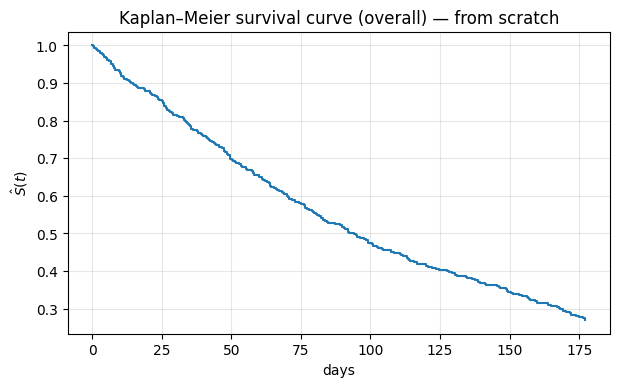

In [7]:
# Plot KM overall (scratch)

fig, ax = plt.subplots(figsize=(7,4), dpi=100)

ax.step(np.r_[0, km_all["time"]], np.r_[1, km_all["survival"]], where="post")
ax.set_title("Kaplan–Meier survival curve (overall) — from scratch")
ax.set_xlabel("days")
ax.set_ylabel("$\\hat S(t)$")
ax.grid(True, alpha=0.3)

plt.show()

### KM by subgroup
We'll compare players with `prev_injury=1` vs `0`.


In [8]:
km0 = km_from_scratch(
    surv.loc[surv["prev_injury"] == 0, "time"],
    surv.loc[surv["prev_injury"] == 0, "event"],
)
km1 = km_from_scratch(
    surv.loc[surv["prev_injury"] == 1, "time"],
    surv.loc[surv["prev_injury"] == 1, "event"],
)

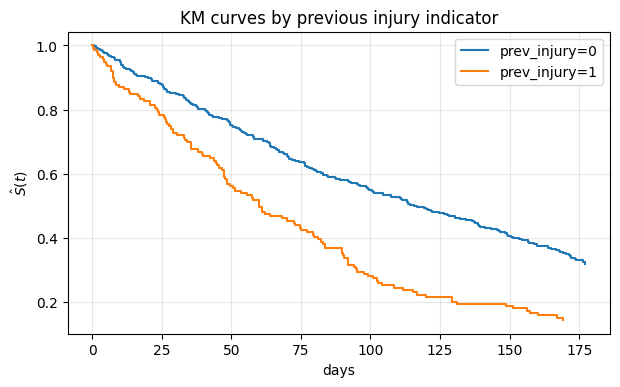

In [9]:
fig, ax = plt.subplots(figsize=(7,4), dpi=100)

ax.step(np.r_[0, km0["time"]], np.r_[1, km0["survival"]], where="post", label="prev_injury=0")
ax.step(np.r_[0, km1["time"]], np.r_[1, km1["survival"]], where="post", label="prev_injury=1")
ax.set_title("KM curves by previous injury indicator")
ax.set_xlabel("days")
ax.set_ylabel("$\\hat S(t)$")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

### Same thing using statsmodels
`SurvfuncRight` computes KM estimates for right-censored data.


In [10]:
sf_all = SurvfuncRight(surv["time"], surv["event"])

# SurvfuncRight stores stepwise survival probabilities at sf_all.surv_times
# We'll report the survival just after a few time points.
def surv_at(sf, t):
    if len(sf.surv_times) == 0:
        return 1.0
    idx = np.searchsorted(sf.surv_times, t, side="right") - 1
    if idx < 0:
        return 1.0
    return float(sf.surv_prob[idx])

for t in [30, 60, 90, 120, 150, 180]:
    print(f"t={t:3d} days: S(t)≈{surv_at(sf_all,t):.3f}")

t= 30 days: S(t)≈0.816
t= 60 days: S(t)≈0.652
t= 90 days: S(t)≈0.518
t=120 days: S(t)≈0.414
t=150 days: S(t)≈0.344
t=180 days: S(t)≈0.270


## Part 5 — Cox proportional hazards (PH) regression

The Cox model is the workhorse of survival regression.


### Model

$$
h(t\mid x) = h_0(t)\exp(\beta^\top x)
$$

- $h_0(t)$ is an unspecified baseline hazard (can vary with time however it wants)
- covariates $x$ enter through a multiplicative factor $\exp(\beta^\top x)$


### Hazard ratio interpretation
If we increase $x_j$ by 1 (holding other covariates fixed):

$$
\frac{h(t\mid x_j+1)}{h(t\mid x_j)} = \exp(\beta_j).
$$

So $\exp(\beta_j)$ is a **hazard ratio**:
- $>1$ means higher hazard (events happen sooner)
- $<1$ means lower hazard (events happen later)


### How it gets fit (sketch)
Cox uses a *partial likelihood* that cancels out the baseline hazard.

If events happen at times $t_i$ for individuals $i\in\mathcal{E}$,
and $R(t_i)$ is the risk set (those still at risk at time $t_i$), then:

$$
L(\beta)
= \prod_{i\in\mathcal{E}}
\frac{\exp(\beta^\top x_i)}{\sum_{j\in R(t_i)}\exp(\beta^\top x_j)}.
$$

This looks a lot like a conditional multinomial / softmax likelihood.


__________
### Deeper dive: how Cox can be fit without specifying $h_0(t)$ (partial likelihood)

A very common question is:

> "If $h_0(t)$ is unknown, how do we estimate $\beta$?"

Cox's key trick is to use comparisons within risk sets. Let $t_1 < t_2 < \cdots$ be the distinct event times (injuries). For an event at time $t$, define the **risk set**:

$$
\mathcal{R}(t) = \{ j : \tilde T_j \ge t \}
$$

i.e., everyone who is still "alive / injury-free / at risk" just before time $t$. Under the Cox model:

$$
h(t\mid x_j)=h_0(t)\exp(\beta^\top x_j).
$$

Therefore
- At time $t$ we know *someone* in $\mathcal{R}(t)$ had the event.
- The probability it was athlete $i$ (among the risk set) is proportional to their hazard.

So:

$$
P(i\text{ is the event at }t \mid \mathcal{R}(t)) = \frac{h_0(t)\exp(\beta^\top x_i)}{\sum_{j\in\mathcal{R}(t)} h_0(t)\exp(\beta^\top x_j)} = \frac{\exp(\beta^\top x_i)}{\sum_{j\in\mathcal{R}(t)} \exp(\beta^\top x_j)}.
$$

The $h_0(t)$ cancels. The *partial likelihood* multiplies these terms over all observed events:

$$
L_p(\beta)=\prod_{\text{events }i} \frac{\exp(\beta^\top x_i)}{\sum_{j\in\mathcal{R}(t_i)} \exp(\beta^\top x_j)}.
$$

Taking logs:

$$
\ell_p(\beta)=\sum_{\text{events }i} \left[ \beta^\top x_i - \log\left(\sum_{j\in\mathcal{R}(t_i)} \exp(\beta^\top x_j)\right) \right].
$$

This looks a lot like a "softmax" / multinomial log-likelihood inside each risk set. *(Ties need a small extension — Breslow and Efron are common approximations — but the core idea is the same.)*

In [11]:
# A tiny worked example of Cox partial likelihood mechanics

toy = pd.DataFrame({
    "id": ["A","B","C","D"],
    "time": [5, 8, 12, 12],   # observed times
    "event": [1, 1, 0, 1],    # C is censored at 12
    "x": [0.2, 1.0, -0.3, 0.7]   # one covariate
})
toy

,id,time,event,x
0,A,5,1,0.2
1,B,8,1,1.0
2,C,12,0,-0.3
3,D,12,1,0.7


In [12]:
def partial_loglik(beta, df):
    """
    Compute the Cox proportional hazards *partial* log-likelihood for a 1D covariate.

    Model and objective
    -------------------
    Cox PH model:
        h(t | x) = h0(t) * exp(beta * x)

    The Cox partial likelihood avoids specifying h0(t) by focusing on *who fails when*.
    For each observed event time t_i (with event_i = 1), the partial likelihood term is:

        exp(beta x_i) / sum_{j in R(t_i)} exp(beta x_j),

    where R(t_i) is the risk set: individuals still at risk just before t_i
    (here, we approximate this as those with observed time >= t_i).

    Taking logs and summing over event rows gives the partial log-likelihood:

        ll(beta) = sum_{i: event_i=1} [ beta x_i - log( sum_{j in R(t_i)} exp(beta x_j) ) ].

    Assumptions / simplifications
    -----------------------------
    - This implementation is for a single covariate named "x".
    - It assumes *no ties* in event times (or treats ties as negligible).
      Proper tie handling uses approximations like Breslow or Efron.

    Parameters
    ----------
    beta : float
        Cox coefficient for covariate x (log hazard ratio per unit x).
    df : pd.DataFrame
        Must contain columns:
        - "time": observed time (event or censoring)
        - "event": 1 if event observed, 0 if right-censored
        - "x": covariate (1D)

    Returns
    -------
    ll : float
        Partial log-likelihood value at beta.
    """

    # Sort by time so risk sets are interpretable and reproducible.
    # (Not strictly required for correctness here, but it clarifies intent.)
    df = df.sort_values("time")

    ll = 0.0

    # Iterate only over rows where an event occurs (these are the only times
    # where the partial likelihood updates).
    for _, row in df[df["event"] == 1].iterrows():
        t = row["time"]

        # Risk set R(t):
        # individuals who are still under observation at time t,
        # i.e., those with observed time >= t.
        # (In continuous-time survival with right-censoring, this is the standard risk set.)
        risk = df[df["time"] >= t]

        # Numerator (log scale): beta * x_i for the individual who failed at time t.
        # This corresponds to log(exp(beta x_i)).
        num = beta * row["x"]

        # Denominator (log scale): log sum_{j in R(t)} exp(beta * x_j).
        # We compute the sum in ordinary space and then take log.
        # Note: for numerical stability with large beta*x, you would usually use log-sum-exp.
        den = np.log(np.sum(np.exp(beta * risk["x"].to_numpy())))

        # Add this event's contribution to the total partial log-likelihood.
        ll += num - den

    return float(ll)


In [13]:
for b in [-2, -1, 0, 1, 2]:
    print(f"beta={b:+.1f}  partial log-lik={partial_loglik(b, toy):.3f}")

beta=-2.0  partial log-lik=-6.373
beta=-1.0  partial log-lik=-4.418
beta=+0.0  partial log-lik=-3.178
beta=+1.0  partial log-lik=-2.714
beta=+2.0  partial log-lik=-2.813


In [14]:
# Show the first event contribution explicitly
beta = 1.0
first_event = toy[(toy["event"]==1)].sort_values("time").iloc[0]
t = first_event["time"]
risk = toy[toy["time"] >= t]

print("\nFirst event at t=", t)
print("Risk set:", list(risk["id"]))


First event at t= 5
Risk set: ['A', 'B', 'C', 'D']


In [15]:
scores = np.exp(beta * risk["x"].to_numpy())
prob = scores / scores.sum()

tmp = pd.DataFrame({
    "id": risk["id"].values,
    "x": risk["x"].values,
    "exp(beta*x)": scores,
    "P(event|risk set)": prob
})
tmp

,id,x,exp(beta*x),P(event|risk set)
0,A,0.2,1.221403,0.182455
1,B,1.0,2.718282,0.406062
2,C,-0.3,0.740818,0.110665
3,D,0.7,2.013753,0.300818


### Fit Cox PH on our injury dataset
We'll scale covariates for interpretability:
- `age5` = (age - 25) / 5   → "per 5 years older"
- `mpg10` = (minutes - 30) / 10 → "per 10 minutes more per game"


In [16]:
surv2 = surv.copy()
surv2["age5"] = (surv2["age"] - 25) / 5
surv2["mpg10"] = (surv2["min_per_game"] - 30) / 10

exog = surv2[["age5","mpg10","prev_injury"]]

cox = PHReg(surv2["time"], exog, status=surv2["event"])
cox_res = cox.fit()
print(cox_res.summary())

                        Results: PHReg
Model:                     PH Reg        Sample size:       500
Dependent variable:        time          Num. events:       365
Ties:                      Breslow                             
---------------------------------------------------------------
            log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
---------------------------------------------------------------
age5        0.2311    0.0699 1.2599 3.3050 0.0009 1.0986 1.4450
mpg10       0.1943    0.0940 1.2144 2.0656 0.0389 1.0100 1.4602
prev_injury 0.6635    0.1143 1.9415 5.8049 0.0000 1.5519 2.4290
Confidence intervals are for the hazard ratios


### Interpreting the Cox PH output (log HR, HR, uncertainty)

A Cox proportional hazards model estimates how covariates *multiplicatively* shift the hazard (instantaneous event rate). For each covariate $x_k$, the model implies:

$$
h(t \mid x) = h_0(t)\exp(\beta^\top x), \quad\text{so}\quad \frac{h(t \mid x_k + 1)}{h(t \mid x_k)} = e^{\beta_k}.
$$

That ratio $e^{\beta_k}$ is the **hazard ratio (HR)** for a one-unit increase in that covariate, holding the others fixed. Because we rescaled,
- `age5 = (age - 25)/5`, a **+1** change means **5 years older**.
- `mpg10 = (minutes - 30)/10`, a **+1** change means **10 more minutes per game**.
- `prev_injury` is 0/1, so a +1 change means **having a previous injury vs not**.

________
How to read each column:

- **log HR**: the estimated coefficient $\hat\beta_k$ (log hazard ratio). Positive means higher hazard (earlier injuries on average), negative means lower hazard.
- **HR**: $e^{\hat\beta_k}$, the hazard ratio.  
  - HR $= 1$ means no association with hazard.
  - HR $> 1$ means higher hazard (events happen sooner).
  - HR $< 1$ means lower hazard (events happen later).
- **log HR SE**: standard error of $\hat\beta_k$, used to quantify uncertainty.
- **t** and **P>|t|**: a Wald test of $H_0:\beta_k = 0$ (equivalently HR $= 1$).
- **[0.025, 0.975]**: a 95% confidence interval for the HR (here, shown on the HR scale).

Interpretations from our table:

- `age5` has HR $\approx 1.26$: **each additional 5 years of age** is associated with about a **26% higher hazard** of injury at any given time, holding mpg and injury history fixed.
- `mpg10` has HR $\approx 1.21$: **each additional 10 minutes per game** is associated with about a **21% higher hazard** of injury, holding other covariates fixed.
- `prev_injury` has HR $\approx 1.94$: players with a previous injury have about a **94% higher hazard** of injury than those without, holding age and mpg fixed.

Two important reminders:

1. **“Hazard” is not “probability.”** An HR of 1.26 does *not* mean a 26% higher probability of injury by season end; it means a 26% higher *instantaneous event rate* at each time $t$.
2. The Cox model leaves $h_0(t)$ unspecified, so these are **relative effects**. You can compare groups (via HRs) without committing to a parametric baseline survival curve.


_________
We'll compute hazard ratios and 95% confidence intervals:

$$
\text{HR}_j = e^{\hat\beta_j}, \quad \text{CI: } e^{\hat\beta_j \pm 1.96\cdot SE(\hat\beta_j)}.
$$


In [17]:
params = pd.Series(cox_res.params, index=exog.columns)
ses = pd.Series(cox_res.bse, index=exog.columns)

hr = np.exp(params)
ci_lo = np.exp(params - 1.96*ses)
ci_hi = np.exp(params + 1.96*ses)

hr_tbl = pd.DataFrame({
    "beta_hat": params,
    "SE": ses,
    "hazard_ratio": hr,
    "HR_2.5%": ci_lo,
    "HR_97.5%": ci_hi,
})
hr_tbl

,beta_hat,SE,hazard_ratio,HR_2.5%,HR_97.5%
age5,0.231071,0.069916,1.259949,1.098598,1.444997
mpg10,0.194261,0.094046,1.214413,1.009980,1.460226
prev_injury,0.663474,0.114296,1.941525,1.551858,2.429037


### Predicted survival curves for hypothetical profiles

If we estimate baseline cumulative hazard $\hat H_0(t)$, then for covariates $x$:

$$
\hat S(t\mid x) = \exp\left(-\hat H_0(t)\exp(\hat\beta^\top x)\right).
$$

We'll plot survival for three profiles:
1. younger / low minutes / no prior injury  
2. average  
3. older / high minutes / prior injury


In [18]:
# Extract baseline cumulative hazard from statsmodels PHReg
# baseline_cumulative_hazard is a list; for a single-stratum model it's length 1.
base = cox_res.baseline_cumulative_hazard[0]
t0 = base[0]         # event times
H0 = base[1]         # cumulative hazard at those times

In [19]:
def predicted_survival_curve(x_row, params, t0=t0, H0=H0):
    # x_row should align with params order
    linpred = float(np.dot(x_row, params))
    mult = math.exp(linpred)
    S = np.exp(-H0 * mult)
    return t0, S

In [20]:
profiles = pd.DataFrame({
    "age5": [ (22-25)/5,  (26.5-25)/5, (33-25)/5 ],
    "mpg10":[ (20-30)/10, (28-30)/10,  (38-30)/10 ],
    "prev_injury":[0, 0, 1],
}, index=["young_low_noPrev", "avg_noPrev", "older_high_prev"])

In [21]:
profiles


,age5,mpg10,prev_injury
young_low_noPrev,-0.6,-1.0,0
avg_noPrev,0.3,-0.2,0
older_high_prev,1.6,0.8,1


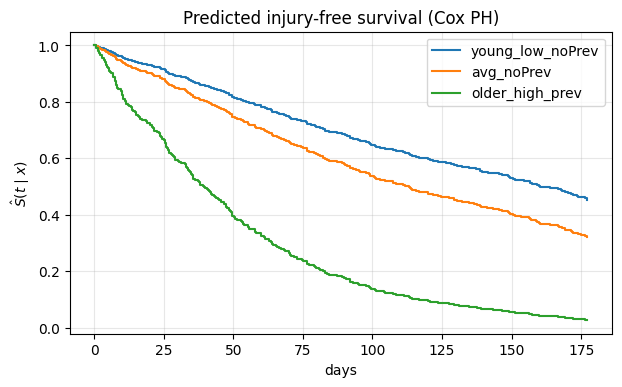

In [22]:
fig, ax = plt.subplots(figsize=(7,4), dpi=100)

for name, row in profiles.iterrows():
    tt, S = predicted_survival_curve(row.values, params.values)
    ax.step(np.r_[0, tt], np.r_[1, S], where="post", label=name)
ax.set_title("Predicted injury-free survival (Cox PH)")
ax.set_xlabel("days")
ax.set_ylabel("$\hat S(t\mid x)$")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## Part 6 — Evaluating survival models (what "good" means)

For logistic regression we asked: "are the probabilities good?"

For survival models we usually ask a slightly different question:

- **Do higher-risk people tend to experience the event earlier?**  
- **Are predicted survival probabilities calibrated over time?**  

There are many survival evaluation metrics (and a whole subfield around time-dependent ROC/AUC and Brier scores). Here are two that show up constantly.

### Concordance index (C-index)
The C-index is the survival analogue of "ranking quality."

Informally:

> Consider pairs of players where we can tell who got injured first.  
> Did the model assign higher risk to the one who got injured earlier?

A common definition (Harrell's C):

$$
C = \frac{\text{\# concordant pairs} + 0.5\times \text{\# tied pairs}}{\text{\# comparable pairs}}.
$$

- $C=0.5$ is "no better than random ranking."
- $C=1.0$ is perfect ordering.

The censoring detail is what makes this nontrivial: not all pairs are comparable.

We'll compute a simple Harrell-style C-index from scratch.


### Brier score at a fixed horizon (and why censoring complicates it)
For survival, the "outcome at time $t$" is whether the event has happened by $t$.

One useful quantity is the survival indicator:

$$
Y_i(t) = I(T_i > t),
$$

which is 1 if player $i$ is still injury-free at time $t$.

If a model predicts $\hat S(t\mid x_i)$, then a natural squared-error score is:

$$
\text{Brier}(t) = \frac{1}{n}\sum_{i=1}^n \left(Y_i(t) - \hat S(t\mid x_i)\right)^2.
$$

But censoring means $Y_i(t)$ is not always observed:
- if a player is censored before $t$, we don't know if they would have been injured before $t$ or not.

A standard fix is **inverse probability of censoring weighting (IPCW)**:
- estimate the censoring survival function $\hat G(t)=P(C>t)$ (often with Kaplan–Meier, treating censoring as the "event"),
- weight each observed term by $1/\hat G(\cdot)$.

We'll compute a simple IPCW Brier score at a few horizons.

In [23]:
# C-index implementation (Harrell's C) for right-censored survival data

def c_index_harrell(time, event, risk_score):
    """
    time: array of observed times (min(T, C))
    event: 1 if event observed, 0 if censored
    risk_score: higher => higher risk (earlier event expected)

    Returns: (c_index, n_pairs)
    """
    time = np.asarray(time)
    event = np.asarray(event)
    risk_score = np.asarray(risk_score)

    n = len(time)
    concordant = 0.0
    ties = 0.0
    comparable = 0.0

    for i in range(n):
        for j in range(i+1, n):
            # Determine which one has the smaller observed time
            if time[i] == time[j]:
                # If both have events at the same time, it's comparable but tied in time.
                # Many implementations treat this carefully; we'll skip exact-tie times for simplicity.
                continue

            # Let i be the one with smaller time
            if time[i] < time[j]:
                ti, tj = time[i], time[j]
                ei, ej = event[i], event[j]
                ri, rj = risk_score[i], risk_score[j]
            else:
                ti, tj = time[j], time[i]
                ei, ej = event[j], event[i]
                ri, rj = risk_score[j], risk_score[i]

            # Pair is comparable if the earlier time is an event (not censored)
            # and the later person was still "at risk" at that time (tj > ti, which we have).
            if ei == 1:
                comparable += 1
                if ri > rj:
                    concordant += 1
                elif ri == rj:
                    ties += 1
                # else discordant

    if comparable == 0:
        return np.nan, 0
    return (concordant + 0.5 * ties) / comparable, int(comparable)

In [24]:
# Risk score for Cox PH is linear predictor: eta = beta^T x
eta = np.asarray(exog @ cox_res.params)

c, n_pairs = c_index_harrell(surv2["time"], surv2["event"], eta)
print(f"C-index (Cox PH, Harrell): {c:.3f}  (comparable pairs: {n_pairs:,})")

C-index (Cox PH, Harrell): 0.594  (comparable pairs: 115,705)


In [25]:
# Baseline sanity checks:
c0, n0 = c_index_harrell(surv2["time"], surv2["event"], np.zeros_like(eta))
cr, nr = c_index_harrell(surv2["time"], surv2["event"], RNG.normal(size=len(eta)))

print(f"C-index (all tied risk):   {c0:.3f}")
print(f"C-index (random risk):     {cr:.3f}")

C-index (all tied risk):   0.500
C-index (random risk):     0.504


In [26]:
# IPCW Brier score at a few horizons for the Cox model

def step_at(times, values, t, start_value=1.0):
    """Return the right-continuous step function value at time t.
    times should be sorted increasing; values are the step values *after* each time.
    """
    times = np.asarray(times)
    values = np.asarray(values)
    if len(times) == 0 or t < times[0]:
        return float(start_value)
    idx = np.searchsorted(times, t, side="right") - 1
    return float(values[idx])

In [27]:
# 1) Estimate censoring survival G(t) via Kaplan–Meier on censoring indicator
#    censor_event = 1 if censored, 0 if injury observed
censor_event = 1 - surv2["event"].to_numpy()
km_cens = km_from_scratch(surv2["time"], censor_event)

def G_hat(t):
    # survival of censoring time: P(C > t)
    return step_at(km_cens["time"].values, km_cens["survival"].values, t, start_value=1.0)


In [28]:
# 2) Predicted survival S_hat(t | x) from Cox model
params = cox_res.params  # already defined above
tt_base, _ = predicted_survival_curve(exog.iloc[0].values, params)  # baseline event times

In [29]:
def S_hat_individual(t, x_row):
    tt, S = predicted_survival_curve(x_row, params)
    return step_at(tt, S, t, start_value=1.0)

def brier_ipcw(t):
    times = surv2["time"].to_numpy()
    events = surv2["event"].to_numpy()
    X = exog.to_numpy()

    # Y_i(t) = I(T_i > t) for true event time T_i. We only observe it when not censored before t.
    # IPCW weights:
    # - if event observed by t: weight = 1 / G_hat(time_i)
    # - if still at risk at t: weight = 1 / G_hat(t)
    # - if censored before t: contribute 0
    eps = 1e-12
    Gt = max(G_hat(t), eps)

    sqerr = []
    wts = []

    for ti, di, xi in zip(times, events, X):
        shat = S_hat_individual(t, xi)

        if di == 1 and ti <= t:
            # event observed before horizon
            Gi = max(G_hat(ti), eps)
            yi = 0.0
            w = 1.0 / Gi
            sqerr.append((yi - shat) ** 2)
            wts.append(w)

        elif ti > t:
            # still observed (not event yet, and not censored yet) at horizon
            yi = 1.0
            w = 1.0 / Gt
            sqerr.append((yi - shat) ** 2)
            wts.append(w)

        # else: censored before t => skip

    if len(sqerr) == 0:
        return np.nan

    sqerr = np.asarray(sqerr)
    wts = np.asarray(wts)
    return float(np.mean(wts * sqerr))

In [30]:
for t in [30, 60, 90, 120, 150]:
    print(f"Brier_IPCW(t={t:3d}): {brier_ipcw(t):.4f}")

Brier_IPCW(t= 30): 0.1471
Brier_IPCW(t= 60): 0.2178
Brier_IPCW(t= 90): 0.2367
Brier_IPCW(t=120): 0.2226
Brier_IPCW(t=150): 0.2110


## Part 7 — The bridge: discrete-time survival is logistic regression

Sometimes time is naturally discrete:
- days in a season
- matches in a season
- possessions in a game
- plate appearances

In discrete time, the hazard at time step $t$ is:

$$
h_t(x) = P(T=t \mid T\ge t, X=x).
$$

A common model is:

$$
\text{logit}(h_t(x)) = \alpha_t + \beta^\top x
$$

where $\alpha_t$ is a time-specific intercept (or a smooth function of time).

### Turning survival data into a "person-period" dataset
For each individual $i$ with observed time $\tilde T_i$ and event indicator $\delta_i$:

Create rows for $t=1,2,\dots,\tilde T_i$ with:
- `event_at_t` = 1 only on the final row if $\delta_i=1$
- else 0

Then fit a logistic regression to predict `event_at_t`.

This estimates hazards; then you can recover survival:

$$
\hat S(t\mid x) = \prod_{u=1}^t (1 - \hat h_u(x)).
$$


In [31]:
# Build person-period data (daily) for discrete-time hazard modeling

def make_person_period(df, max_t=180):
    rows = []
    for i, r in df.reset_index(drop=True).iterrows():
        T = int(np.round(r["time"]))
        T = max(1, min(T, max_t))
        for t in range(1, T+1):
            event_at_t = 1 if (r["event"]==1 and t==T) else 0
            rows.append({
                "id": i,
                "t": t,
                "event_at_t": event_at_t,
                "age5": (r["age"] - 25) / 5,
                "mpg10": (r["min_per_game"] - 30) / 10,
                "prev_injury": r["prev_injury"],
            })
    return pd.DataFrame(rows)

surv_sub = surv.sample(n=min(250, len(surv)), random_state=7)
pp = make_person_period(surv_sub, max_t=180)
print("Rows in person-period data:", len(pp))
pp.head()


Rows in person-period data: 26873


,id,t,event_at_t,age5,mpg10,prev_injury
0,0,1,0,0.023055,0.035241,1.0
1,0,2,0,0.023055,0.035241,1.0
2,0,3,0,0.023055,0.035241,1.0
3,0,4,0,0.023055,0.035241,1.0
4,0,5,0,0.023055,0.035241,1.0


### Fit a discrete-time hazard model with logistic regression

We'll use a flexible-but-simple time effect:
- $t$ and $t^2$ as covariates (a crude smooth curve)

In a more serious application, you'd use:
- time dummies ($\alpha_t$)
- splines
- piecewise constant hazards


In [32]:
pp["t_scaled"] = pp["t"] / 180.0
pp["t2"] = pp["t_scaled"]**2

X = pp[["t_scaled","t2","age5","mpg10","prev_injury"]]
y = pp["event_at_t"]

# Logistic regression with regularization (helps with large-ish datasets)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000))
])
pipe.fit(X, y)

# Show average predicted hazard at a few times for an "average" player
def predict_hazard(t, age5=0.0, mpg10=0.0, prev_injury=0):
    t_scaled = t/180.0
    row = pd.DataFrame({
        "t_scaled":[t_scaled],
        "t2":[t_scaled**2],
        "age5":[age5],
        "mpg10":[mpg10],
        "prev_injury":[prev_injury],
    })
    return float(pipe.predict_proba(row)[:,1])

for t in [1, 30, 60, 120, 180]:
    print(f"t={t:3d}: hazard≈{predict_hazard(t):.4f}")


t=  1: hazard≈0.0045
t= 30: hazard≈0.0048
t= 60: hazard≈0.0051
t=120: hazard≈0.0054
t=180: hazard≈0.0054


### From predicted hazard to survival curve
Given predicted hazards $\hat h_1,\hat h_2,\dots$, compute:

$$
\hat S(t)=\prod_{u=1}^t (1-\hat h_u).
$$

We'll compare discrete-time survival curves for the same three profiles we used for Cox.


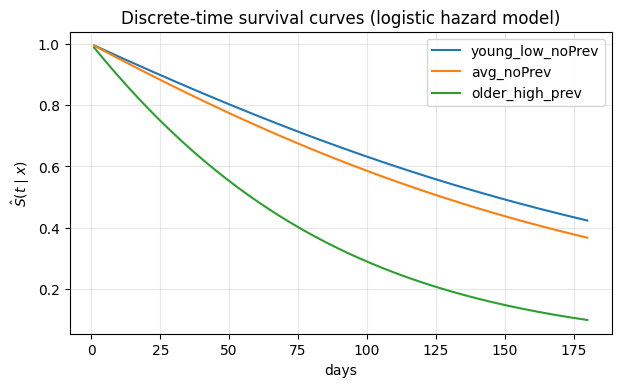

In [33]:
def discrete_survival_curve(age5, mpg10, prev_injury, t_max=180):
    hs = np.array([predict_hazard(t, age5=age5, mpg10=mpg10, prev_injury=prev_injury) for t in range(1, t_max+1)])
    S = np.cumprod(1 - hs)
    ts = np.arange(1, t_max+1)
    return ts, S

profiles_dt = profiles.copy()  # from earlier Cox section

fig, ax = plt.subplots(figsize=(7,4), dpi=100)
for name, r in profiles_dt.iterrows():
    ts, S = discrete_survival_curve(r["age5"], r["mpg10"], r["prev_injury"], t_max=180)
    ax.plot(ts, S, label=name)
ax.set_title("Discrete-time survival curves (logistic hazard model)")
ax.set_xlabel("days")
ax.set_ylabel("$\hat S(t\mid x)$")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


## Part 8 — Extra survival example (match level): time to first goal

Time-to-event ideas show up directly **inside matches**, not just across seasons.

Let $T$ be the minute of the first goal in a match.

- If no goals are scored, the observation is right-censored at (say) $T=95$ minutes.

This is a nice sports example because:
- everybody understands the event,
- censoring is natural (matches end),
- the "time scale" is obvious (minutes).

### What covariates would we use in a real model?
Just to make the ideas concrete, here are common ingredients:

- **Pre-match expected goals / "total-goals line."**  
  Sportsbooks often publish an over/under for total goals (e.g., 2.5).  
  You can treat that as a noisy summary of expected scoring intensity.

- **Relative team strength (Elo).**  
  Elo is a rating system originally developed for chess; in sports it's often used as a single-number strength rating that updates after each game.

- **Match importance** (knockout vs league), **weather**, **altitude**, **red cards**, etc.

We'll simulate a match-level dataset (so we control the truth) and fit KM + Cox quickly.


In [34]:
def simulate_match_first_goal(n_matches=800, rng=RNG):
    # pre-match expected total goals (rough proxy)
    pre_xg = np.clip(rng.normal(2.6, 0.6, size=n_matches), 0.8, 5.0)

    # knockout matches might start tighter
    knockout = rng.binomial(1, 0.25, size=n_matches)

    # baseline hazard per minute
    lambda0 = 0.020

    # hazard multiplier via a Cox-style structure
    # higher pre_xg -> earlier goal (higher hazard)
    # knockout -> slightly lower hazard
    beta = np.array([0.45, -0.25])  # pre_xg, knockout
    X = np.column_stack([pre_xg - 2.6, knockout])
    hazard = lambda0 * np.exp(X @ beta)

    # exponential time to first goal
    T = rng.exponential(scale=1/hazard)

    # censor at 95
    C = 95.0
    time = np.minimum(T, C)
    event = (T <= C).astype(int)

    dfm = pd.DataFrame({"time": time, "event": event, "pre_xg": pre_xg, "knockout": knockout})
    return dfm, beta

match, beta_match_true = simulate_match_first_goal()
print("No-goal rate:", (1 - match["event"].mean()).round(3))
match.head()


No-goal rate: 0.152


,time,event,pre_xg,knockout
0,6.017052,1,2.584036,0
1,52.540421,1,1.354916,0
2,24.063537,1,3.402730,0
3,95.000000,0,2.664711,0
4,95.000000,0,1.897353,1


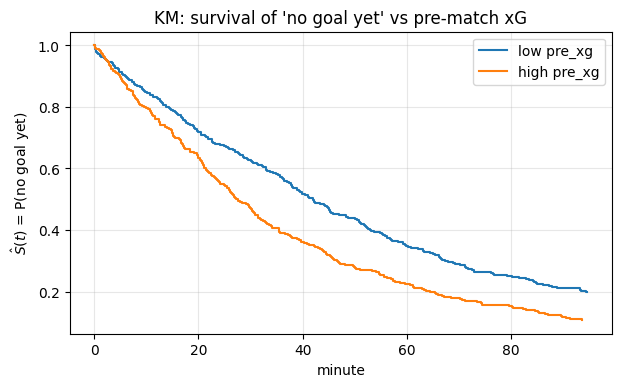

In [35]:
# KM curves for low vs high pre_xg matches
med = match["pre_xg"].median()
low = match[match["pre_xg"] <= med]
high = match[match["pre_xg"] > med]

km_low = km_from_scratch(low["time"], low["event"])
km_high = km_from_scratch(high["time"], high["event"])

fig, ax = plt.subplots(figsize=(7,4), dpi=100)
ax.step(np.r_[0, km_low["time"]], np.r_[1, km_low["survival"]], where="post", label="low pre_xg")
ax.step(np.r_[0, km_high["time"]], np.r_[1, km_high["survival"]], where="post", label="high pre_xg")
ax.set_title("KM: survival of 'no goal yet' vs pre-match xG")
ax.set_xlabel("minute")
ax.set_ylabel("$\hat S(t)$ = P(no goal yet)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


In [36]:
# Cox PH on match data
match2 = match.copy()
match2["pre_xg_c"] = match2["pre_xg"] - match2["pre_xg"].mean()

exog = match2[["pre_xg_c","knockout"]]
cox_m = PHReg(match2["time"], exog, status=match2["event"]).fit()
print(cox_m.summary())

hr_m = np.exp(pd.Series(cox_m.params, index=exog.columns))
print("\nHazard ratios:")
print(hr_m)


                        Results: PHReg
Model:                    PH Reg        Sample size:       800
Dependent variable:       time          Num. events:       678
Ties:                     Breslow                             
--------------------------------------------------------------
          log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
--------------------------------------------------------------
pre_xg_c  0.3181    0.0638 1.3746  4.9845 0.0000 1.2129 1.5577
knockout -0.2542    0.0943 0.7755 -2.6964 0.0070 0.6447 0.9329
Confidence intervals are for the hazard ratios

Hazard ratios:
pre_xg_c    1.374567
knockout    0.775504
dtype: float64


## Wrap-up: what to remember (logistic + survival)

### Logistic regression
- For binary outcomes, $E[Y\mid X]=P(Y=1\mid X)$.
- Logistic regression models log-odds linearly:

  $$
  \log\left(\frac{p}{1-p}\right) = \beta_0 + \beta^\top x
  $$

- Fit by maximum likelihood (equivalently, minimize log-loss):

  $$
  \mathcal{L}(\beta) = -\frac{1}{n}\sum_i \left[y_i\log p_i + (1-y_i)\log(1-p_i)\right].
  $$

- Interpret coefficients via odds ratios: $e^{\beta_j}$.
- For sports probability models (xG, WP), focus on:
  - log-loss
  - calibration
  - sensible feature engineering

### Survival analysis
- Survival function: $S(t)=P(T>t)$
- Hazard: $h(t)=f(t)/S(t)$ and $S(t)=e^{-H(t)}$.
- Kaplan–Meier estimates $S(t)$ nonparametrically (handles censoring).
- Cox PH models:

  $$
  h(t\mid x)=h_0(t)e^{\beta^\top x}
  $$

  and interprets $e^{\beta_j}$ as a hazard ratio.

### Bridge
- In discrete time, hazards can be modeled with logistic regression.


__________
## Next time...
Regression Pt. 5 — Bayesian Stats and the "Hot Hand" `class_09_bayesian_hot_hand.ipynb`


## References and further reading

I'm putting **more references than we strictly need** here so you have an on-ramp if you want to go deeper (or you're using these tools in a project).

### Survival analysis fundamentals (the classics)
- Kaplan, E. L., & Meier, P. (1958). *Nonparametric estimation from incomplete observations.* Journal of the American Statistical Association.
- Cox, D. R. (1972). *Regression models and life-tables (with discussion).* Journal of the Royal Statistical Society: Series B.
- Clark, T. G., Bradburn, M. J., Love, S. B., & Altman, D. G. (2003). *Survival analysis part I: basic concepts and first analyses.* British Journal of Cancer.  
  (This is one of the cleanest "first survival tutorial" papers.)
- Stevenson, M. (2007). *An Introduction to Survival Analysis.* (Very readable notes.)

If you want a textbook:  
- Klein, J. P., & Moeschberger, M. L. (2003). *Survival Analysis: Techniques for Censored and Truncated Data.*

### Survival analysis in sports / sports medicine
- Nielsen, R. O., Bertelsen, M. L., Ramskov, D., et al. (2019). *Time-to-event analysis for sports injury research part 1: time-varying exposures.* British Journal of Sports Medicine.  
  (Key idea: in sports, predictors like training load change over time, so your data structure has to match that.)
- "Model Sports Injuries as Events" (example workflow for injury as time-to-event).
- Ferer, I. (2020). *Quantifying the Value of an NHL Timeout using Survival Analysis.* Hockey Graphs.  
  (Great example of survival thinking inside games.)

### Logistic regression / GLMs (general)
- Hastie, Tibshirani, Friedman. *The Elements of Statistical Learning* (ESL).
- James, Witten, Hastie, Tibshirani. *An Introduction to Statistical Learning* (ISLR).
- Hosmer, Lemeshow, Sturdivant. *Applied Logistic Regression.*

### Sports probability models (xG, expected points, win probability)
- Pollard, Ensum, & Taylor (early 2000s): early logistic regression style shot-conversion models in soccer.
- Macdonald (2012): early public-facing NHL expected goals work (MIT Sloan).
- Spearman (2018): tracking-data extensions ("Beyond Expected Goals").

### Software docs / tutorials (bookmark these)
- scikit-learn logistic regression: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- statsmodels Logit: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html
- statsmodels survival (PHReg, SurvfuncRight): https://www.statsmodels.org/stable/duration.html

**scikit-survival** (recommended survival ML toolkit):
- Intro user guide (HTML): https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html
- GitHub user guide notebooks: https://github.com/sebp/scikit-survival/tree/v0.27.0/doc/user_guide
- Model evaluation notebook: https://github.com/sebp/scikit-survival/blob/v0.27.0/doc/user_guide/evaluating-survival-models.ipynb

---

## Appendix A — Logistic regression gradient derivation (full algebra)

In Part 3 we quoted the key result:

$$
\nabla\mathcal{L}(\beta) = \frac{1}{n}X^\top(p-y).
$$

Here's the full derivation in slow motion.

### Step 0: write the model clearly
For observation $i$:

- linear predictor: $z_i = x_i^\top\beta$
- probability: $p_i = \sigma(z_i)=\frac{1}{1+e^{-z_i}}$
- Bernoulli log-likelihood:
  $$
  \ell_i(\beta)= y_i\log p_i + (1-y_i)\log(1-p_i).
  $$

The **average negative log-likelihood** (the thing we *minimize*) is:

$$
\mathcal{L}(\beta)= -\frac{1}{n}\sum_{i=1}^n \ell_i(\beta).
$$

So it's enough to compute $\frac{\partial}{\partial\beta}\ell_i(\beta)$.

### Step 1: the derivative of the sigmoid
Start with:

$$
p_i = \sigma(z_i)=\frac{1}{1+e^{-z_i}}.
$$

Differentiate w.r.t. $z_i$:

$$
\frac{dp_i}{dz_i} = p_i(1-p_i).
$$

(You can check this by hand or memorize it — it's one of the most useful one-line derivatives in applied stats.)

### Step 2: chain rule through $z_i=x_i^\top\beta$
Because $z_i=x_i^\top\beta$ is linear in $\beta$:

$$
\frac{\partial z_i}{\partial \beta} = x_i.
$$

So by the chain rule:

$$
\frac{\partial p_i}{\partial\beta}
= \frac{dp_i}{dz_i}\frac{\partial z_i}{\partial\beta}
= p_i(1-p_i)\,x_i.
$$

### Step 3: differentiate the log-likelihood
Differentiate:

$$
\ell_i(\beta)= y_i\log p_i + (1-y_i)\log(1-p_i).
$$

Use:
- $\frac{d}{d\beta}\log p_i = \frac{1}{p_i}\frac{\partial p_i}{\partial\beta}$
- $\frac{d}{d\beta}\log(1-p_i) = -\frac{1}{1-p_i}\frac{\partial p_i}{\partial\beta}$

Then:

$$
\frac{\partial\ell_i}{\partial\beta}
= y_i\frac{1}{p_i}\frac{\partial p_i}{\partial\beta}
- (1-y_i)\frac{1}{1-p_i}\frac{\partial p_i}{\partial\beta}.
$$

Factor out $\frac{\partial p_i}{\partial\beta}=p_i(1-p_i)x_i$:

$$
\frac{\partial\ell_i}{\partial\beta}
= \left( y_i\frac{1}{p_i} - (1-y_i)\frac{1}{1-p_i} \right) p_i(1-p_i)x_i.
$$

Simplify the bracket:

$$
y_i\frac{1}{p_i}p_i(1-p_i) = y_i(1-p_i),
$$

$$
(1-y_i)\frac{1}{1-p_i}p_i(1-p_i) = (1-y_i)p_i.
$$

So:

$$
\frac{\partial\ell_i}{\partial\beta}
= \left[y_i(1-p_i) - (1-y_i)p_i\right]x_i
= (y_i - p_i)x_i.
$$

### Step 4: stack and flip the sign (because we minimize negative log-likelihood)
Summing over $i$ and averaging:

$$
\nabla\left(-\frac{1}{n}\sum_i\ell_i\right)
= \frac{1}{n}\sum_i (p_i-y_i)x_i
= \frac{1}{n}X^\top(p-y).
$$

That's the whole story.

### Hessian (one more line)
Differentiate the gradient once more and you get:

$$
\nabla^2\mathcal{L}(\beta) = \frac{1}{n}X^\top W X,
\quad
W=\mathrm{diag}(p_i(1-p_i)).
$$

This is why Newton/IRLS looks like "weighted least squares."


---

## Appendix B — Logistic regression as a GLM (exponential family viewpoint)

If you've seen generalized linear models (GLMs), logistic regression is the Bernoulli GLM with the **canonical link**.

### Bernoulli in exponential family form
The Bernoulli pmf can be written:

$$
P(Y=y) = p^y(1-p)^{1-y}.
$$

Define the natural parameter:

$$
\theta = \log\left(\frac{p}{1-p}\right).
$$

Solve for $p$:

$$
p = \frac{e^{\theta}}{1+e^{\theta}} = \sigma(\theta).
$$

Now rewrite the pmf:

$$
P(Y=y) = \exp\left(y\theta - \log(1+e^{\theta})\right).
$$

This matches the exponential family template:

$$
P(Y=y\mid\theta)=\exp\left(y\theta - b(\theta) + c(y)\right)
$$

with:

- $b(\theta)=\log(1+e^{\theta})$  
- $c(y)=0$ (for Bernoulli)

### Where the "linear predictor" comes from
A GLM assumes the natural parameter is linear in features:

$$
\theta_i = x_i^\top\beta.
$$

Because $p_i=\sigma(\theta_i)$, we get exactly the logistic regression model we've been using.

### One conceptual benefit of this view
The log-likelihood is concave (negative log-likelihood is convex) because:

$$
b''(\theta)=\sigma(\theta)(1-\sigma(\theta)) \ge 0.
$$

That curvature is why Newton/IRLS works so well in practice.


---

## Appendix C — Numerical stability: sigmoid and log-loss in code

In theory:

$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$

In floating point arithmetic, $e^{\pm z}$ can overflow for large $|z|$.

The same issue shows up in log-loss. A stable way to compute terms like
$\log(1+e^{z})$ is to use the "log-sum-exp" trick.

Below is a small "engineering" appendix: not new math, just what you do so the math survives contact with real computers.


In [37]:
# Stable sigmoid and stable log-loss (pure numpy)

def sigmoid_stable(z):
    z = np.asarray(z)
    out = np.empty_like(z, dtype=float)

    pos = z >= 0
    neg = ~pos

    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def logloss_stable(y, z):
    """Compute log-loss from logits z (not probabilities) stably.
    If p = sigmoid(z), log-loss is:
        -y log p - (1-y) log(1-p)
    A stable form uses logaddexp:
        log(1+exp(z)) = logaddexp(0, z)
    """
    y = np.asarray(y)
    z = np.asarray(z)
    return np.mean(np.logaddexp(0, z) - y*z)

# Demo: extreme logits
z_ext = np.array([-1000, -50, -10, 0, 10, 50, 1000], dtype=float)

print("z:", z_ext)
print("naive sigmoid:", sigmoid(z_ext))          # may warn/overflow
print("stable sigmoid:", sigmoid_stable(z_ext))  # should be safe

# Compare log-loss computations
y_demo = np.array([0,0,0,0,1,1,1])
p_naive = sigmoid(z_ext)
p_stable = sigmoid_stable(z_ext)

# probability-based logloss needs clipping
def logloss_from_p(y, p, eps=1e-15):
    p = np.clip(p, eps, 1-eps)
    return float(np.mean(-(y*np.log(p) + (1-y)*np.log(1-p))))

print("\nLog-loss from clipped probabilities:", logloss_from_p(y_demo, p_naive))
print("Log-loss from logits (stable):         ", float(logloss_stable(y_demo, z_ext)))


z: [-1000.   -50.   -10.     0.    10.    50.  1000.]
naive sigmoid: [0.00000000e+00 1.92874985e-22 4.53978687e-05 5.00000000e-01
 9.99954602e-01 1.00000000e+00 1.00000000e+00]
stable sigmoid: [0.00000000e+00 1.92874985e-22 4.53978687e-05 5.00000000e-01
 9.99954602e-01 1.00000000e+00 1.00000000e+00]

Log-loss from clipped probabilities: 0.09903399690834043
Log-loss from logits (stable):          0.09903399690833999


---

## Appendix D — Perfect separation (why coefficients can "blow up")

A subtle but important edge case in logistic regression:

> If your features can separate the classes perfectly, the maximum likelihood estimate does not exist (coefficients go to $\pm\infty$).

Intuition:  
If the model can make $p_i\to 1$ for all $y_i=1$ and $p_i\to 0$ for all $y_i=0$, the log-likelihood keeps improving as coefficients grow.

In sports this can happen when:
- a feature is almost a "cheat code" (e.g., you accidentally leak the label),
- you have a tiny dataset with a strong signal,
- you have highly granular categorical features with few examples (player IDs, rare play types, etc.).

**Regularization** (L2 / L1) fixes this in practice by penalizing huge coefficients.


In [38]:
# A toy perfect-separation example

# Construct a perfectly separable dataset:
# x < 0 => y=0, x > 0 => y=1
x = np.r_[-np.ones(20), np.ones(20)]
y = np.r_[np.zeros(20), np.ones(20)]

X_sm = sm.add_constant(pd.DataFrame({"x": x}))

print("Trying statsmodels Logit on perfectly separated data...")
try:
    res_sep = sm.Logit(y, X_sm).fit(disp=False)
    print(res_sep.summary())
except Exception as e:
    print("statsmodels struggled (as expected):", repr(e))

print("\nNow try scikit-learn with L2 regularization (always regularized by default):")
lr = LogisticRegression(C=1.0, max_iter=2000)
lr.fit(x.reshape(-1,1), y)
print("coef:", lr.coef_, "intercept:", lr.intercept_)
print("predicted probabilities at x=-1 and x=+1:", lr.predict_proba([[-1],[1]])[:,1])


Trying statsmodels Logit on perfectly separated data...
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Feb 2026   Pseudo R-squ.:                   1.000
Time:                        14:27:20   Log-Likelihood:            -1.4310e-10
converged:                      False   LL-Null:                       -27.726
Covariance Type:            nonrobust   LLR p-value:                 9.578e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001   8.36e+04  -1.79e-09      1.000   -1.64e+05    1.64e+05
x             26.3564   8.36e+04      0.000      1.000   -1.64e+05    1.64e

---

## Appendix E — Survival analysis deeper dives (sports-flavored)

This appendix collects a few "next questions" that come up immediately once you start using survival models seriously.

### E1) Deriving $S(t)=\exp(-H(t))$
Start from the hazard definition identity:

$$
h(t)=\frac{f(t)}{S(t)}.
$$

Because $f(t)=F'(t)$ and $S(t)=1-F(t)$, we have:

$$
f(t) = -S'(t).
$$

So:

$$
h(t)=\frac{-S'(t)}{S(t)}.
$$

Rearrange:

$$
\frac{S'(t)}{S(t)} = -h(t).
$$

Integrate both sides from $0$ to $t$:

$$
\int_0^t \frac{S'(u)}{S(u)}\,du = -\int_0^t h(u)\,du.
$$

Left side is $\log S(t)-\log S(0)$. Since $S(0)=1$, $\log S(0)=0$:

$$
\log S(t) = -H(t),
\quad\text{so}\quad
S(t)=e^{-H(t)}.
$$

### E2) Nelson–Aalen estimator (cumulative hazard)
Kaplan–Meier estimates survival directly:

$$
\hat S(t) = \prod_{t_j\le t}\left(1-\frac{d_j}{n_j}\right).
$$

Nelson–Aalen estimates cumulative hazard:

$$
\hat H(t)=\sum_{t_j\le t} \frac{d_j}{n_j}.
$$

Then you can "convert" it into a survival curve via:

$$
\tilde S(t)=\exp(-\hat H(t)).
$$

KM and Nelson–Aalen are closely related; they often look nearly the same in practice.

### E3) Proportional hazards assumption (PH)
Cox PH assumes:

$$
\frac{h(t\mid x_a)}{h(t\mid x_b)} = \exp\left(\beta^\top(x_a-x_b)\right),
$$

which does **not** depend on $t$.

In sports language: the relative injury risk for "older vs younger" is assumed to be roughly constant throughout the season. Sometimes that's fine; sometimes it's not.

When PH is violated, common fixes include:
- adding interactions with time (time-varying effects),
- switching to an accelerated failure time (AFT) model,
- using flexible machine learning survival models (random survival forests, gradient boosting, etc.).


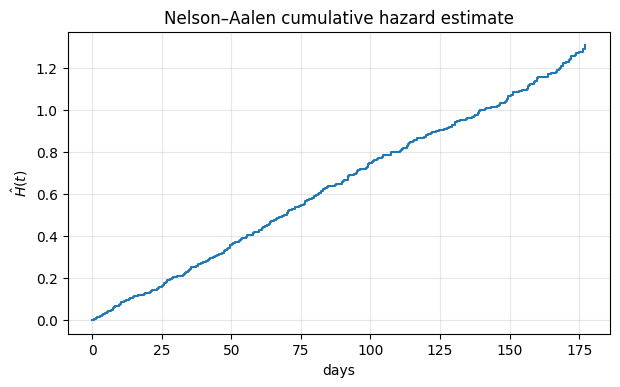

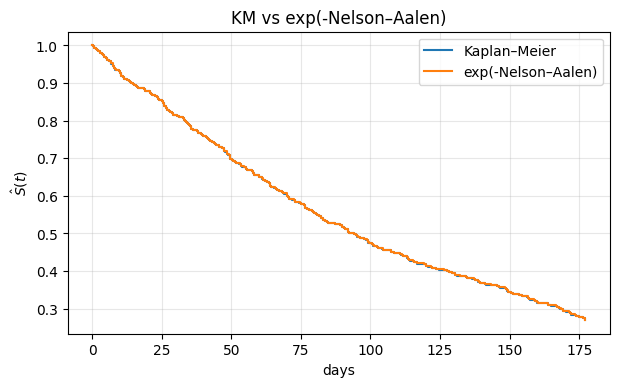

In [39]:
# Nelson–Aalen from scratch on our injury dataset

def nelson_aalen(time, event):
    df = pd.DataFrame({"time": time, "event": event}).sort_values("time")
    event_times = np.sort(df.loc[df["event"] == 1, "time"].unique())
    H = 0.0
    rows = []
    for t in event_times:
        n_at_risk = int((df["time"] >= t).sum())
        d = int(((df["time"] == t) & (df["event"] == 1)).sum())
        H += d / n_at_risk
        rows.append({"time": t, "n_at_risk": n_at_risk, "d_events": d, "H": H})
    out = pd.DataFrame(rows)
    out["S_from_H"] = np.exp(-out["H"])
    return out

na = nelson_aalen(surv2["time"], surv2["event"])

fig, ax = plt.subplots(figsize=(7,4), dpi=100)
ax.step(np.r_[0, na["time"]], np.r_[0, na["H"]], where="post")
ax.set_title("Nelson–Aalen cumulative hazard estimate")
ax.set_xlabel("days")
ax.set_ylabel("$\hat H(t)$")
ax.grid(True, alpha=0.3)
plt.show()

# Compare KM vs exp(-H)
km_all = km_from_scratch(surv2["time"], surv2["event"])

fig, ax = plt.subplots(figsize=(7,4), dpi=100)
ax.step(np.r_[0, km_all["time"]], np.r_[1, km_all["survival"]], where="post", label="Kaplan–Meier")
ax.step(np.r_[0, na["time"]], np.r_[1, na["S_from_H"]], where="post", label="exp(-Nelson–Aalen)")
ax.set_title("KM vs exp(-Nelson–Aalen)")
ax.set_xlabel("days")
ax.set_ylabel("$\hat S(t)$")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


---

## Appendix F — Time-varying exposures in sports injury (training load example)

One of the most common "real" complications in sports injury research is that the predictors change over time.

Examples:
- minutes played accumulates
- training load fluctuates by week
- sleep/stress changes
- a player returns from injury (risk profile shifts)

This is discussed explicitly in the sports-injury methods literature.

Below is a **toy** simulation that illustrates the *data shape* you need when a covariate changes over time.

### A simple weekly training-load story
We'll simulate:
- weekly training load for each athlete (think "total high-speed running distance" or "session RPE" — the details don't matter here),
- injury risk that increases when load spikes.

Then we'll fit a **discrete-time hazard model** with logistic regression on the person-week dataset.

This is not the only way to do time-varying covariates (Cox models can do it too), but it's a clean on-ramp because it reuses the logistic regression machinery.


In [40]:
# Simulate weekly training load with time-varying injury risk (discrete time)

def simulate_training_load_survival(n_athletes=250, n_weeks=20, rng=RNG):
    """
    Returns:
      pp: person-week DataFrame (one row per athlete-week until first injury or end)
      summary: athlete-level (time, event) summary
    """

    # Baseline athlete traits
    base_fitness = rng.normal(0, 1, size=n_athletes)   # latent "fitness" (higher => can tolerate load)
    prev_injury = rng.binomial(1, 0.25, size=n_athletes)

    rows = []
    for i in range(n_athletes):
        injured = False
        chronic = 0.0
        last_load = 0.0

        for w in range(1, n_weeks+1):
            # Weekly load with some persistence + noise
            load = 1.2 + 0.4*base_fitness[i] + 0.6*last_load + rng.normal(0, 0.6)
            load = max(0.0, load)
            last_load = load

            # "Chronic" load: a toy exponentially weighted moving average
            chronic = 0.7*chronic + 0.3*load

            # Spike: acute minus chronic
            spike = load - chronic

            if not injured:
                # True (simulated) discrete-time hazard model
                z = -3.2 + 1.4*spike + 0.8*prev_injury[i] - 0.6*base_fitness[i]
                h = float(sigmoid(z))                      # P(injury in week w | injury-free so far)
                event = int(rng.binomial(1, h))
                if event == 1:
                    injured = True
            else:
                h = np.nan
                event = 0

            rows.append({
                "id": i,
                "week": w,
                "load": load,
                "chronic": chronic,
                "spike": spike,
                "fitness": base_fitness[i],
                "prev_injury": prev_injury[i],
                "event_at_week": event,
            })

            if injured:
                break

    pp = pd.DataFrame(rows)
    summary = (pp.groupby("id", as_index=False)
               .agg(time=("week","max"),
                    event=("event_at_week","max")))
    return pp, summary

pp_week, summary_week = simulate_training_load_survival()

print(summary_week["event"].value_counts())
print("Injury rate over 20-week window:", summary_week["event"].mean().round(3))

# Fit discrete-time hazard with logistic regression
X = pp_week[["week","load","chronic","spike","fitness","prev_injury"]].copy()
X["week_scaled"] = X["week"]/X["week"].max()
X = X.drop(columns=["week"])

y = pp_week["event_at_week"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000))
])
pipe.fit(X, y)

coef = pipe.named_steps["lr"].coef_.ravel()
cols = X.columns
coef_tbl = pd.DataFrame({"feature": cols, "coef": coef}).sort_values("coef", ascending=False)
coef_tbl


event
1    213
0     37
Name: count, dtype: int64
Injury rate over 20-week window: 0.852


,feature,coef
2,spike,0.849708
4,prev_injury,0.275586
5,week_scaled,0.164056
0,load,0.146070
1,chronic,-0.322584
3,fitness,-0.351556


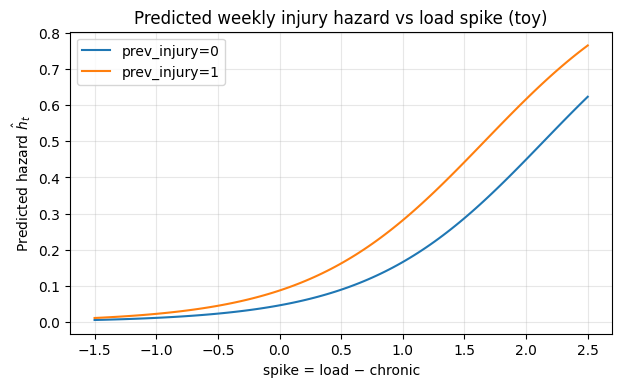

In [41]:
# Visualize how predicted weekly injury hazard changes with a load spike

spikes = np.linspace(-1.5, 2.5, 120)
chronic0 = 1.0
load0 = chronic0 + spikes

def pred_hazard_from_spike(spike, prev_injury=0, fitness=0.0, week_scaled=0.5, chronic=1.0):
    load = chronic + spike
    Xrow = pd.DataFrame({
        "load": [load],
        "chronic": [chronic],
        "spike": [spike],
        "fitness": [fitness],
        "prev_injury": [prev_injury],
        "week_scaled": [week_scaled],
    })
    return float(pipe.predict_proba(Xrow)[0,1])

haz0 = [pred_hazard_from_spike(s, prev_injury=0) for s in spikes]
haz1 = [pred_hazard_from_spike(s, prev_injury=1) for s in spikes]

fig, ax = plt.subplots(figsize=(7,4), dpi=100)
ax.plot(spikes, haz0, label="prev_injury=0")
ax.plot(spikes, haz1, label="prev_injury=1")
ax.set_title("Predicted weekly injury hazard vs load spike (toy)")
ax.set_xlabel("spike = load − chronic")
ax.set_ylabel("Predicted hazard $\hat h_t$")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


### Interpreting time-varying covariates (the core idea)

In the person-week dataset, each athlete contributes one row per week until injury/censoring.

That means:

- The model is learning something like:  
  "**given you were injury-free at the start of week $t$**, what is the probability you get injured during week $t$?"

That's exactly a discrete-time hazard, and it's why logistic regression is such a natural tool here.

The *hard* parts in real injury studies are usually not the math — they're:
- defining the exposure metric (what does "load" mean, exactly?),
- aligning timestamps correctly (who was at risk when?),
- handling multiple injuries per athlete (recurrent events),
- dealing with informative missingness (who leaves the study and why?).

Those are research design questions as much as modeling questions.
